# Imports

In [1]:
%run -i implementations.py

Imports loaded.
Decision tree functions loaded.
Neural net functions loaded.


# Data loading

In [2]:
df_train = pd.read_csv('../data/df_train.csv')
df_test = pd.read_csv('../data/df_test.csv')

features = list(df_train.columns[:-1])

In [3]:
# split data into features and labels for train and test datasets 
X_train, y_train = get_features_and_labels(df_train)
X_test, y_test = get_features_and_labels(df_test)

# Exploratory data analysis
Analysis done on the training set.

In [4]:
# Set colour theme for seaborn
palette_colour = sns.color_palette("hls", 6)
cmap = sns.color_palette("ch:start=.2,rot=-.3", as_cmap=True)

# dictionary mapping the numbers to class names
types = {
    1: 'Window from building (float processed)',
    2: 'Window from building (non-float processed)',
    3: 'Window from vehicle',
    5: 'Container',
    6: 'Tableware',
    7: 'Headlamp' 
}

In [5]:
# df with readable glass types
eda = df_train.copy(deep=True)
eda['type_name'] = eda['type'].map(types)

In [6]:
X_train.dtypes

RI    float64
Na    float64
Mg    float64
Al    float64
Si    float64
K     float64
Ca    float64
Ba    float64
Fe    float64
dtype: object

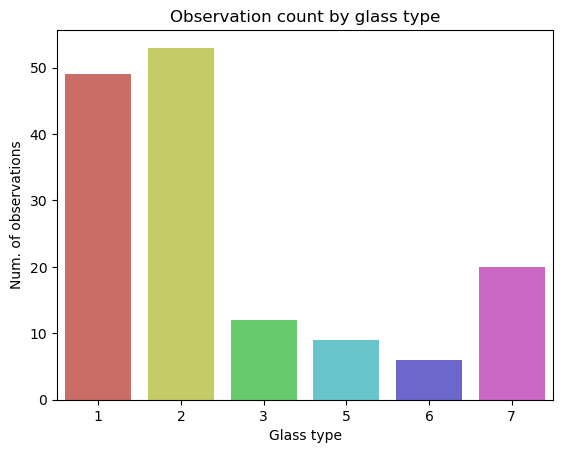

In [7]:
# checking how balanced the dataset is
leg = list(types.values())
ax = sns.countplot(x='type', data=eda, palette=palette_colour)
plt.setp(ax.get_xticklabels(), rotation=0)
ax.set_title('Observation count by glass type')
ax.set_ylabel('Num. of observations')
ax.set_xlabel('Glass type');

In [8]:
# quantiles for all features
round(X_train.describe(), 2)#.to_csv('describe.csv')

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
count,149.00,149.00,149.00,149.00,149.00,149.00,149.00,149.00,149.00
mean,1.52,13.42,2.72,1.43,72.62,0.49,8.92,0.20,0.06
std,0.00,0.86,1.42,0.51,0.78,0.57,1.51,0.55,0.10
min,1.51,10.73,0.00,0.29,69.81,0.00,5.43,0.00,0.00
25%,1.52,12.93,2.28,1.17,72.28,0.13,8.22,0.00,0.00
50%,1.52,13.30,3.49,1.36,72.78,0.55,8.59,0.00,0.00
75%,1.52,13.83,3.61,1.62,73.05,0.61,9.14,0.00,0.11
max,1.53,17.38,3.98,3.50,75.41,6.21,16.19,3.15,0.37


In [9]:
# correlation matrix for all features
X_train.corr()

,RI,Na,Mg,Al,Si,K,Ca,Ba,Fe
RI,1.000000,-0.260584,-0.156225,-0.393512,-0.541810,-0.288022,0.815106,0.023676,0.097121
Na,-0.260584,1.000000,-0.271648,0.160512,-0.030542,-0.212932,-0.349449,0.282964,-0.238313
Mg,-0.156225,-0.271648,1.000000,-0.424156,-0.126577,0.098270,-0.447793,-0.502356,0.154060
Al,-0.393512,0.160512,-0.424156,1.000000,-0.074505,0.338642,-0.288594,0.490822,-0.151610
Si,-0.541810,-0.030542,-0.126577,-0.074505,1.000000,-0.241871,-0.198236,-0.185238,-0.072297
K,-0.288022,-0.212932,0.098270,0.338642,-0.241871,1.000000,-0.357690,0.016004,-0.014780
Ca,0.815106,-0.349449,-0.447793,-0.288594,-0.198236,-0.357690,1.000000,-0.112389,0.081924
Ba,0.023676,0.282964,-0.502356,0.490822,-0.185238,0.016004,-0.112389,1.000000,-0.071580
Fe,0.097121,-0.238313,0.154060,-0.151610,-0.072297,-0.014780,0.081924,-0.071580,1.000000


In [10]:
# Compute a correlation matrix and convert to long-form
corr_mat_abs = abs(X_train.corr()).stack().reset_index(name="correlation")

# taking absolute value of the correlation, interested in the strength of the relationship, not the direction

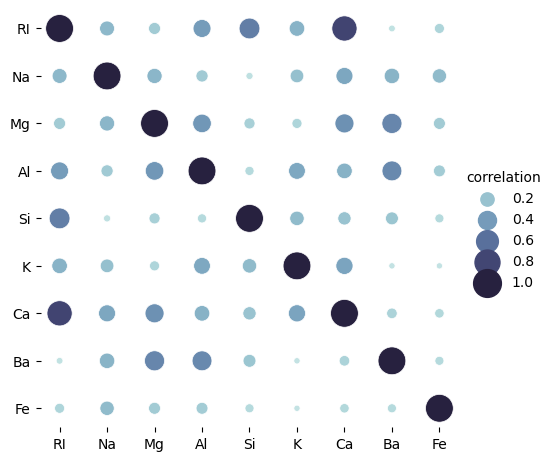

In [11]:
g = sns.relplot(
    data=corr_mat_abs, x="level_0", y="level_1", 
    hue="correlation", size="correlation", 
    palette=cmap, height=5, sizes=(20, 400)
)

g.set(xlabel="", ylabel="", aspect="equal")
g.despine(left=True, bottom=True);

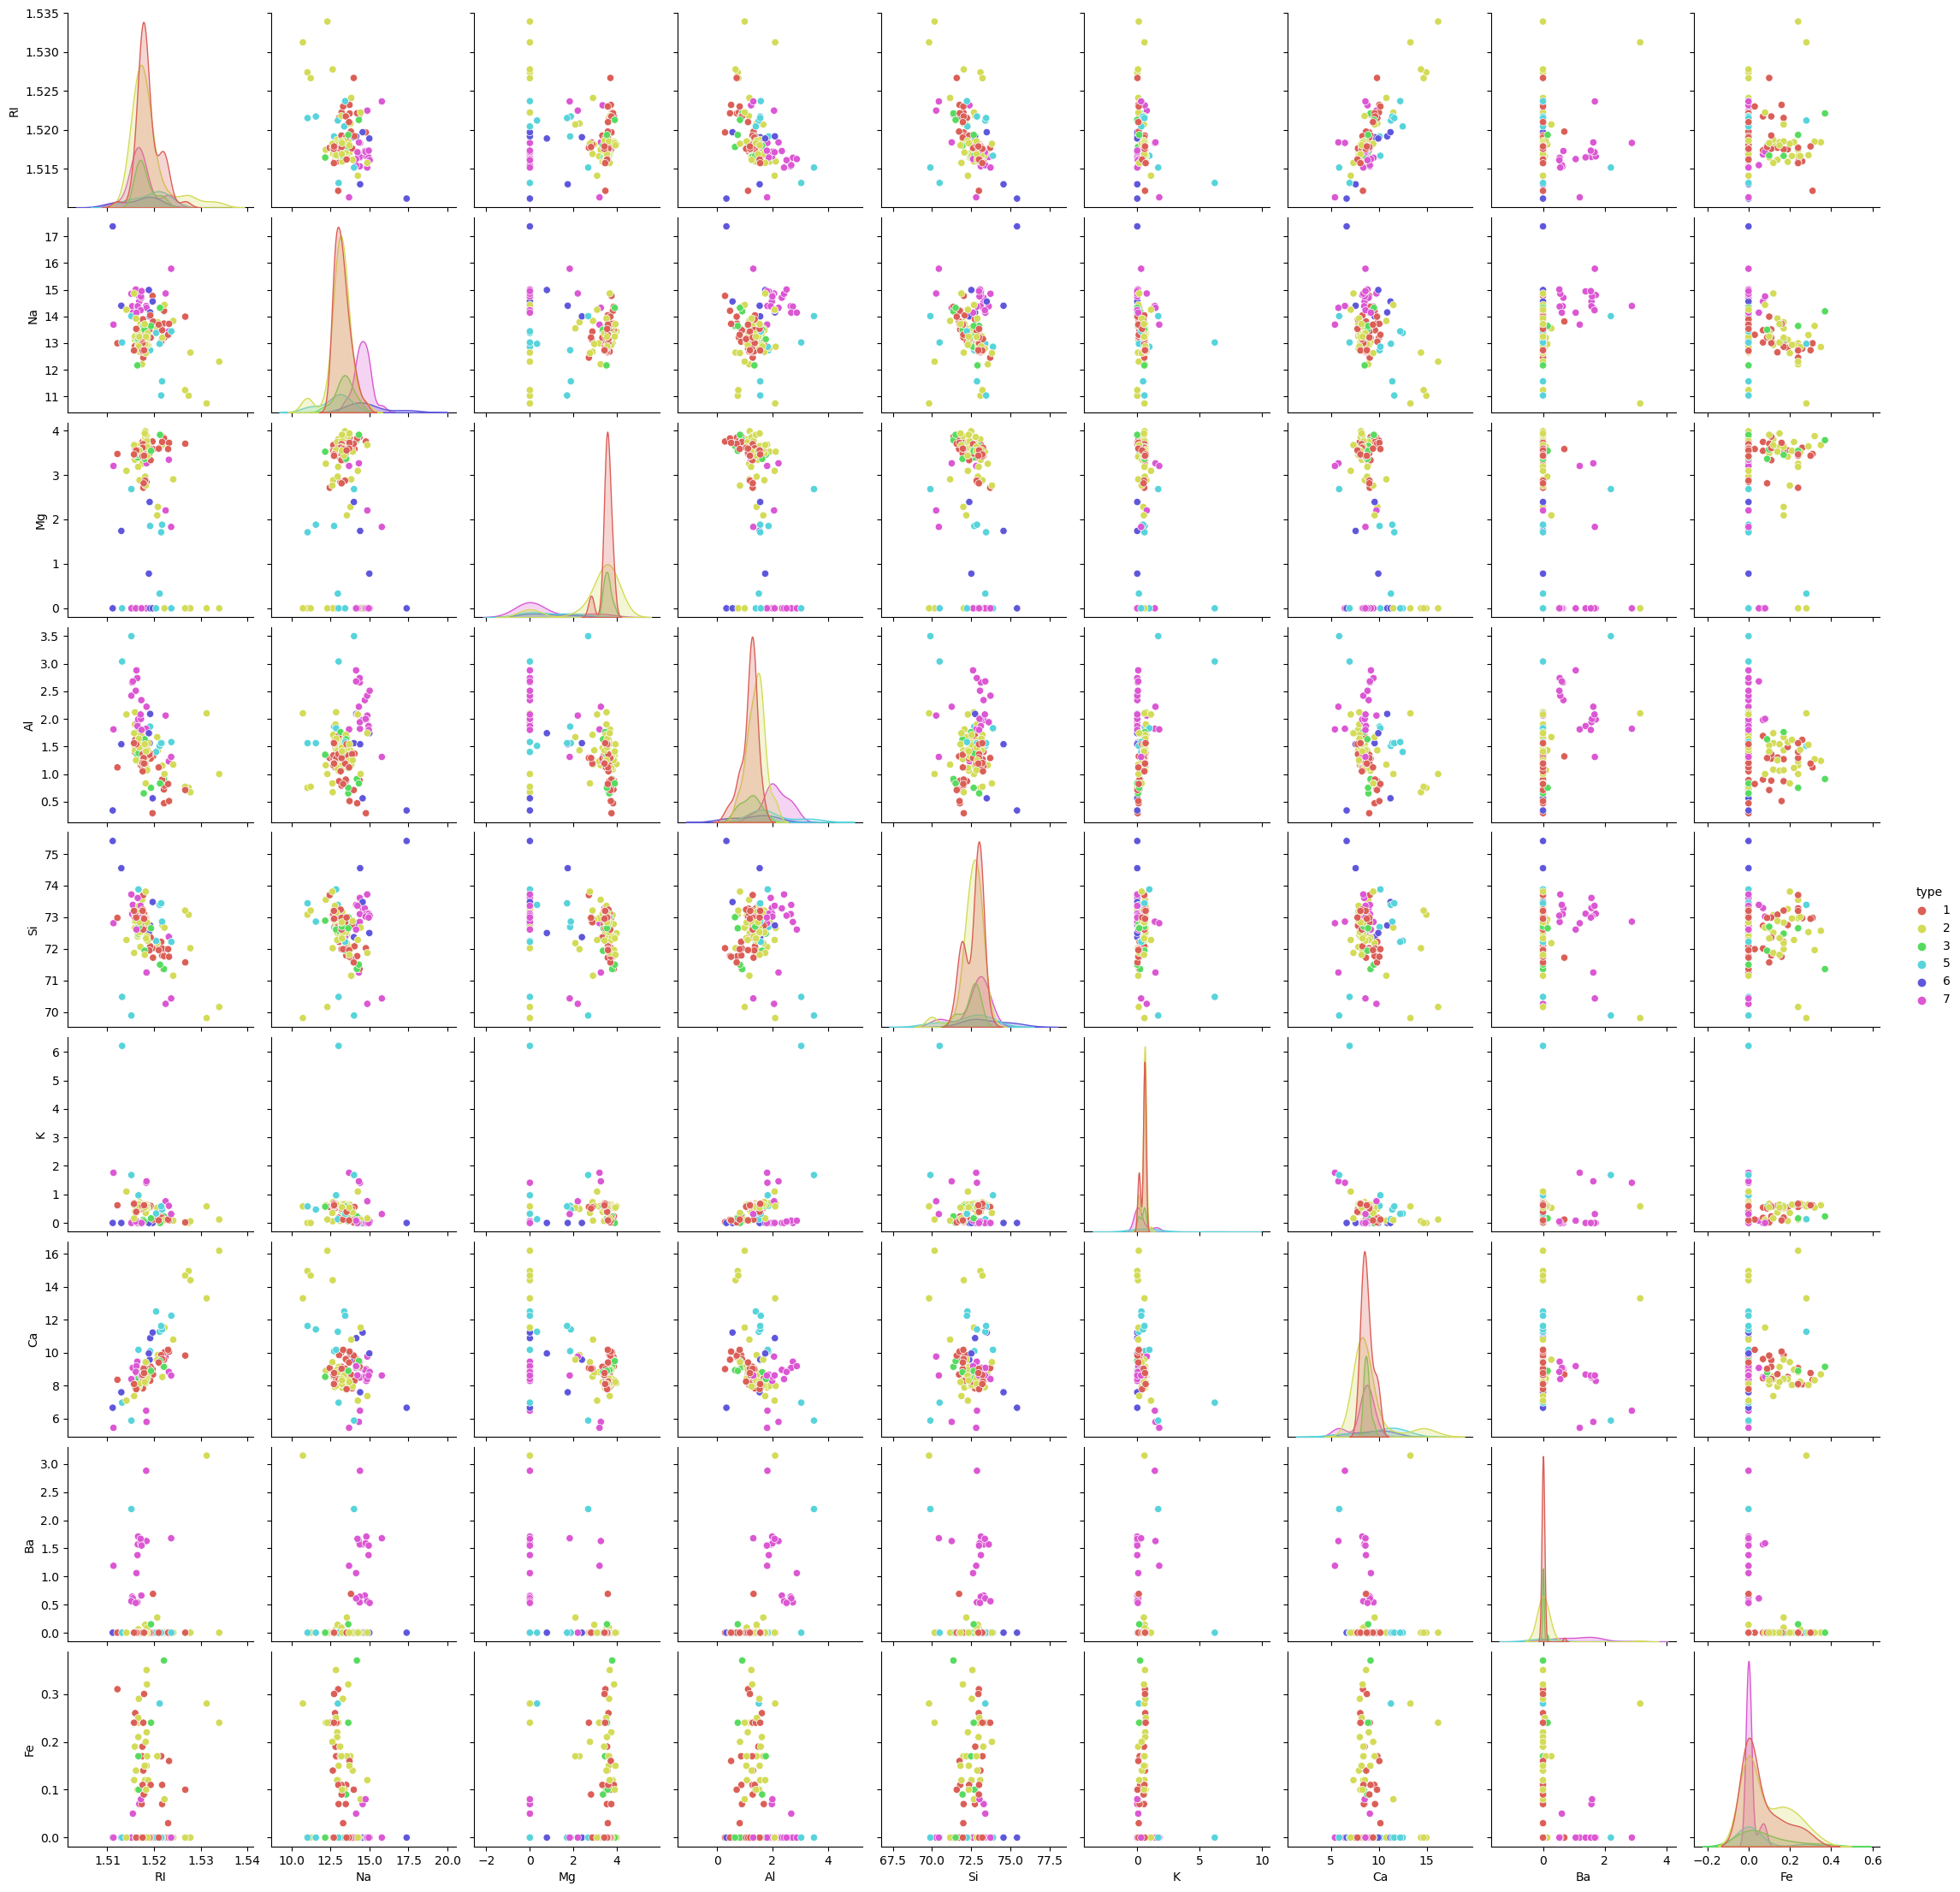

In [12]:
# check distribution and and relationships between features
sns.pairplot(data=eda.loc[:, eda.columns != 'type_name'], hue='type', palette=palette_colour, corner=False);

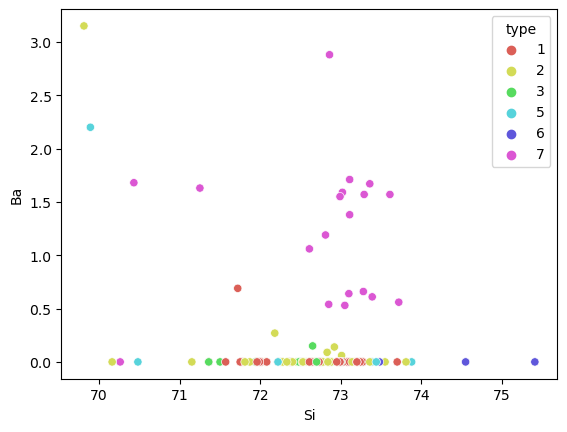

In [13]:
sns.scatterplot(data=eda, x='Si', y='Ba', hue='type', palette=palette_colour);

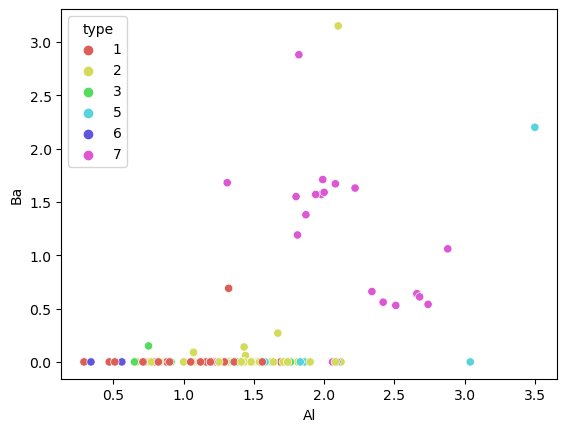

In [14]:
sns.scatterplot(data=eda, x='Al', y='Ba', hue='type', palette=palette_colour);

# Data preprocessing

## Normalisation

Why to normalize prior to model fitting?

The main idea behind normalization/standardization is always the same. Variables that are measured at different scales do not contribute equally to the model fitting & model learned function and might end up creating a bias. Thus, to deal with this potential problem feature-wise normalization such as MinMax Scaling is usually used prior to model fitting.

This can be very useful for some ML models like the Multi-layer Perceptrons (MLP), where the back-propagation can be more stable and even faster when input features are min-max scaled (or in general scaled) compared to using the original unscaled data.

Note: Tree-based models are usually not dependent on scaling, but non-tree models models such as SVM, LDA etc. are often hugely dependent on it.

Source: [1](https://towardsdatascience.com/everything-you-need-to-know-about-min-max-normalization-in-python-b79592732b79)

In [15]:
# normalise feature dataframes
X_train_norm = min_max_normalisation(X_train)
X_test_norm = min_max_normalisation(X_test)

## PCA

The reason why it is critical to perform standardization prior to PCA, is that the latter is quite sensitive regarding the variances of the initial variables. That is, if there are large differences between the ranges of initial variables, those variables with larger ranges will dominate over those with small ranges (For example, a variable that ranges between 0 and 100 will dominate over a variable that ranges between 0 and 1), which will lead to biased results. So, transforming the data to comparable scales can prevent this problem.

Geometrically speaking, principal components represent the directions of the data that explain a maximal amount of variance, that is to say, the lines that capture most information of the data. The relationship between variance and information here, is that, the larger the variance carried by a line, the larger the dispersion of the data points along it, and the larger the dispersion along a line, the more the information it has. To put all this simply, just think of principal components as new axes that provide the best angle to see and evaluate the data, so that the differences between the observations are better visible.

Source: [1](https://builtin.com/data-science/step-step-explanation-principal-component-analysis), [2](https://towardsdatascience.com/pca-using-python-scikit-learn-e653f8989e60)

In [16]:
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA

In [17]:
scaler = StandardScaler()
# Fit on training set only
scaler.fit(X_train)

# apply transform to both the training set and the test set
X_train_scaled = scaler.transform(X_train)
X_test_scaled = scaler.transform(X_test)

In [18]:
# check normalisation
round(np.mean(X_train_scaled),3), round(np.std(X_train_scaled), 3)

(-0.0, 1.0)

#### Explained Variance

In [19]:
exp_var_list = [] # list of explained variance

for i in range(1,10):
    # print(i)
    pca_train_loop = PCA(n_components=i)
    pc_train_loop = pca_train_loop.fit_transform(X_train_scaled)
    exp_var_list.append(round(sum(pca_train_loop.explained_variance_ratio_), 3))

exp_var_list

[0.282, 0.513, 0.677, 0.794, 0.896, 0.952, 0.993, 1.0, 1.0]

/tmp/ipykernel_3631/3596560396.py:1: UserWarning: Ignoring `palette` because no `hue` variable has been assigned.
  ax = sns.lineplot(x=list(range(1,10)), y=exp_var_list, palette=palette_colour)


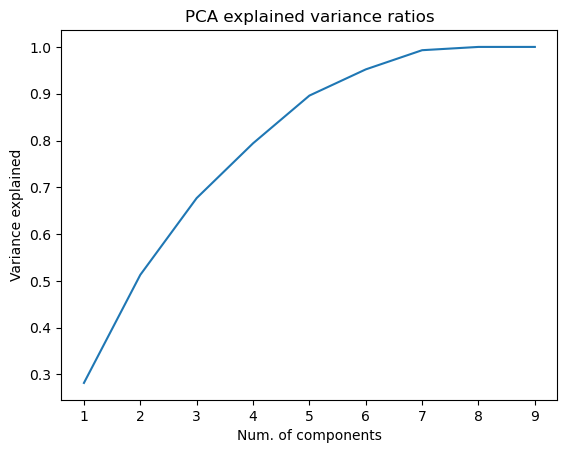

In [20]:
ax = sns.lineplot(x=list(range(1,10)), y=exp_var_list, palette=palette_colour)
ax.set_title('PCA explained variance ratios')
ax.set_xlabel('Num. of components')
ax.set_ylabel('Variance explained')
plt.show()

In [21]:
n=9
pca = PCA(n_components=n)
pca_fit = pca.fit_transform(X_train_scaled)

pca_train = pca.transform(X_train_scaled)
pca_test = pca.transform(X_test_scaled)

exp_var_ratio = pca.explained_variance_ratio_
cum_var_ratio = np.cumsum(pca.explained_variance_ratio_)

print('Percent of variance explained by the {} components: {}'.format(n, round(cum_var_ratio[n-1], 3)))

Percent of variance explained by the 9 components: 1.0


In [22]:
pca_train_df = pd.DataFrame(data = pca_train, columns = list(range(1, n+1)))

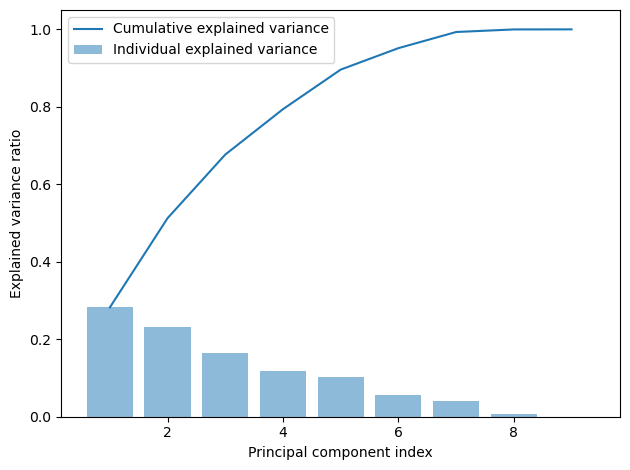

In [23]:
plt.bar(range(1,len(exp_var_ratio)+1), exp_var_ratio, alpha=0.5, align='center', label='Individual explained variance')
plt.plot(range(1,len(cum_var_ratio)+1), cum_var_ratio,label='Cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal component index')
plt.legend(loc='best')
plt.tight_layout()
plt.show()

# source: https://vitalflux.com/pca-explained-variance-concept-python-example/#Explained_Variance_using_Python_Code

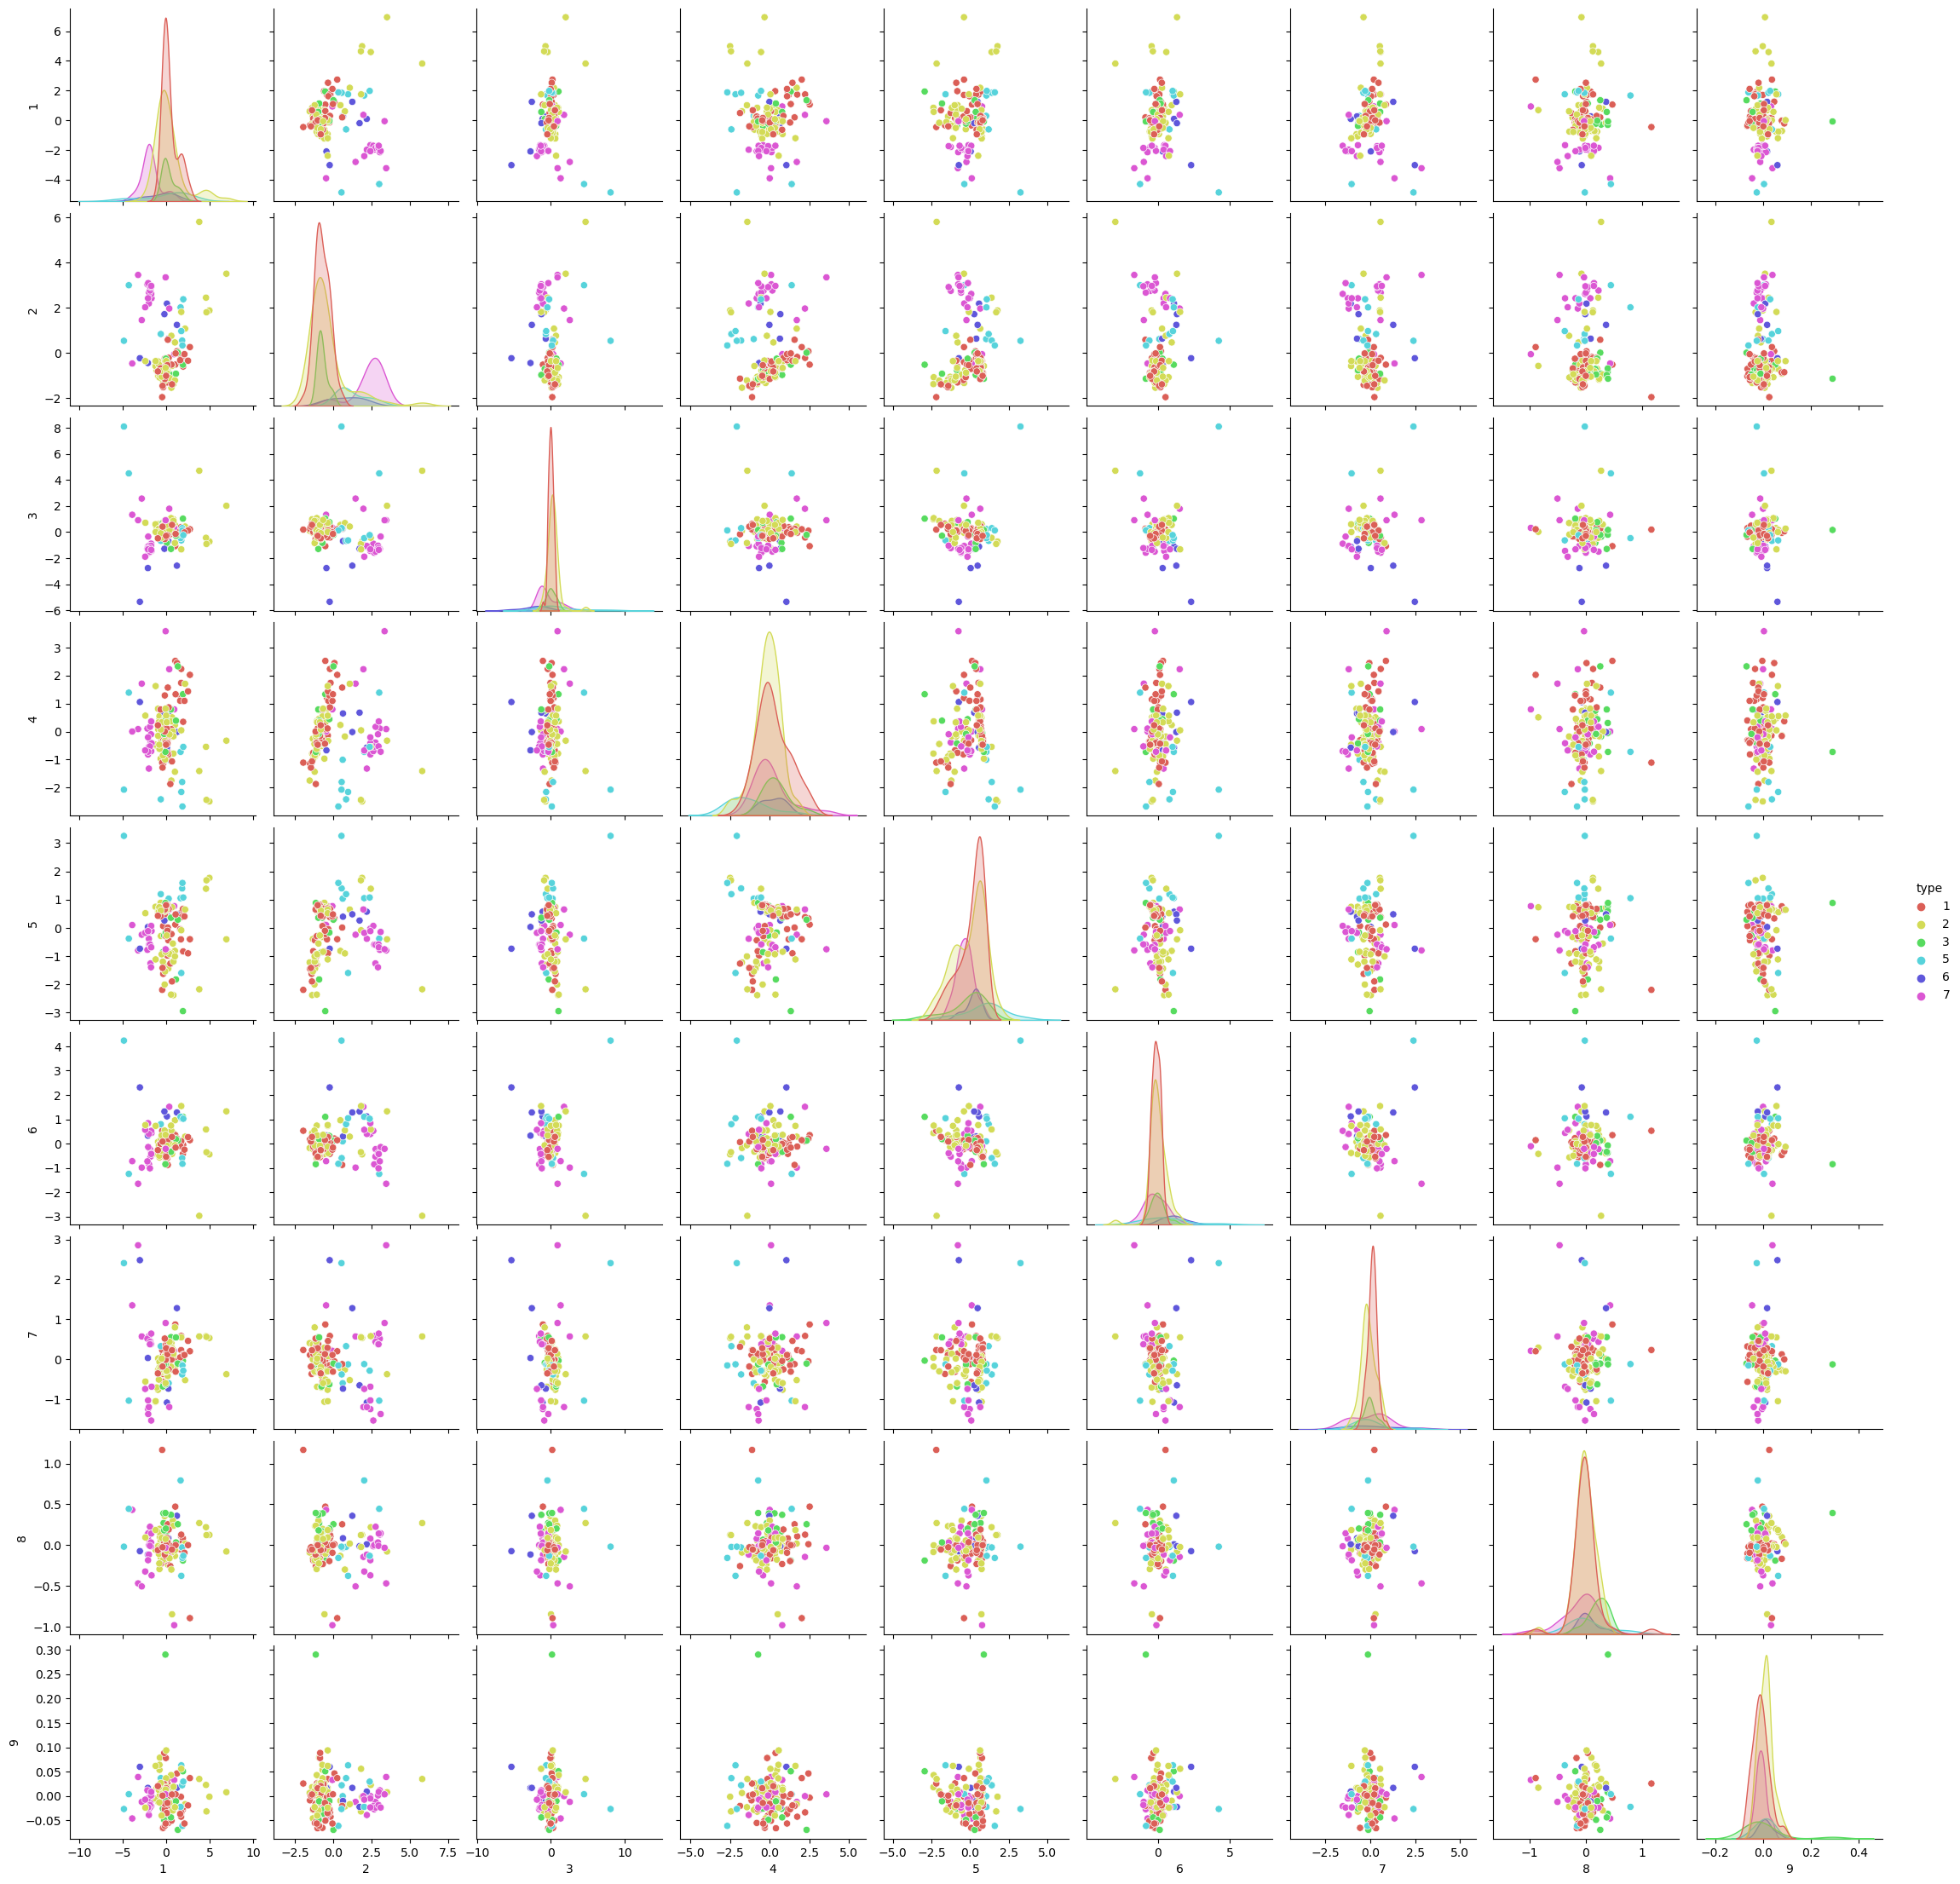

In [24]:
# check distribution and and relationships between principal components
pca_train_df
eda_pca = pca_train_df.copy(deep=True)
eda_pca['type'] = eda['type']
sns.pairplot(data=eda_pca, hue='type', palette=palette_colour, corner=False);

# Implementations

## Decision Tree

In [25]:
# train
tree_dict = decision_tree_train(X_train, y_train, 5)

# predict
dt_predictions = decision_tree_predict(X_test, tree_dict)

In [26]:
dt_accuracy = metrics.accuracy_score(y_test, dt_predictions)
dt_f1 = metrics.f1_score(y_test, dt_predictions, average='weighted')
print('Decision Tree metric on data\nAccuracy: {}\nF1 score: {}'.format(dt_accuracy, dt_f1))

Decision Tree metric on data
Accuracy: 0.7846153846153846
F1 score: 0.7933372183372184


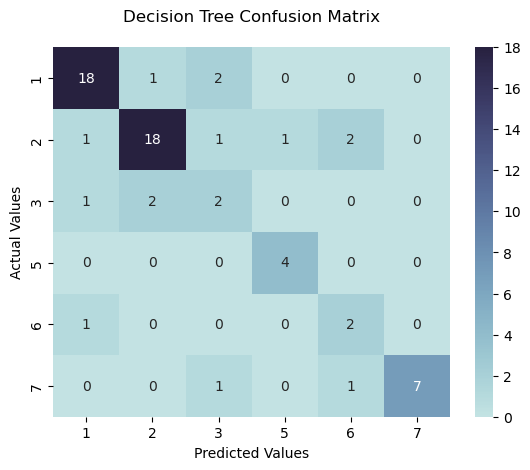

In [27]:
# make and plot confusion matrix
dt_cf_matrix = metrics.confusion_matrix(y_test, dt_predictions)
plot_cf_matrix(dt_cf_matrix, 'Decision Tree Confusion Matrix')

In [28]:
print_tree(tree_dict)

Ba <= 0.4
gini = 0.74
values = [49, 53, 12, 9, 6, 20]
class = 2
--> Al <= 1.42
    gini = 0.68
    values = [48, 52, 12, 8, 6, 2]
    class = 2
--> --> Ca <= 10.48
        gini = 0.61
        values = [43, 23, 10, 1, 2, 1]
        class = 1
--> --> --> Mg <= 3.86
            gini = 0.57
            values = [43, 17, 10, 0, 1, 1]
            class = 1
--> --> --> --> RI <= 1.52
                gini = 0.53
                values = [43, 13, 9, 0, 1, 1]
                class = 1
--> --> --> --> --> RI <= 1.52
                    gini = 0.68
                    values = [2, 3, 5, 0, 1, 0]
                    class = 3
--> --> --> --> --> Fe <= 0.12
                    gini = 0.43
                    values = [41, 10, 4, 0, 0, 1]
                    class = 1
--> --> --> --> RI <= 1.52
                gini = 0.32
                values = [0, 4, 1, 0, 0, 0]
                class = 2
--> --> --> --> --> RI <= 1.52
                    gini = 0.0
                    values = [0, 4, 0, 0, 0, 0]
 

### Comparison to sklearn

In [29]:
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree

clf_pruned = DecisionTreeClassifier(criterion = "gini", 
                                    random_state = 3,
                                    max_depth=5)
clf_pruned.fit(X_train, y_train)

sk_dt_predictions = list(clf_pruned.predict(X_test))
print('Sklearn DecisionTreeClassifier accuracy:', clf_pruned.score(X_test, y_test))

Sklearn DecisionTreeClassifier accuracy: 0.8


In [30]:
dt_sk_accuracy = metrics.accuracy_score(y_test, sk_dt_predictions)
dt_sk_f1 = metrics.f1_score(y_test, sk_dt_predictions, average='weighted')
print('Decision Tree metric on data\nAccuracy: {}\nF1 score: {}'.format(dt_sk_accuracy, dt_sk_f1))

Decision Tree metric on data
Accuracy: 0.8
F1 score: 0.8010859728506788


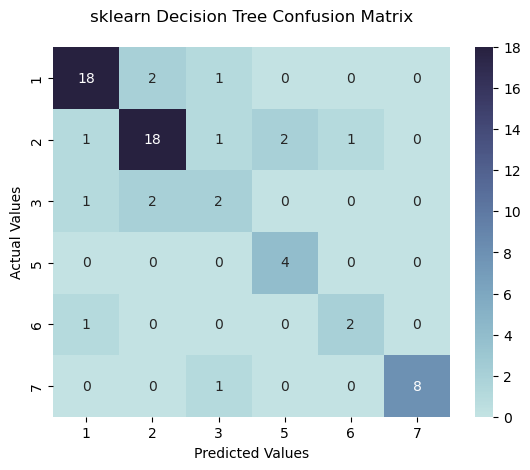

In [31]:
sk_dt_cfm = metrics.confusion_matrix(y_test, sk_dt_predictions)
plot_cf_matrix(sk_dt_cfm, 'sklearn Decision Tree Confusion Matrix')

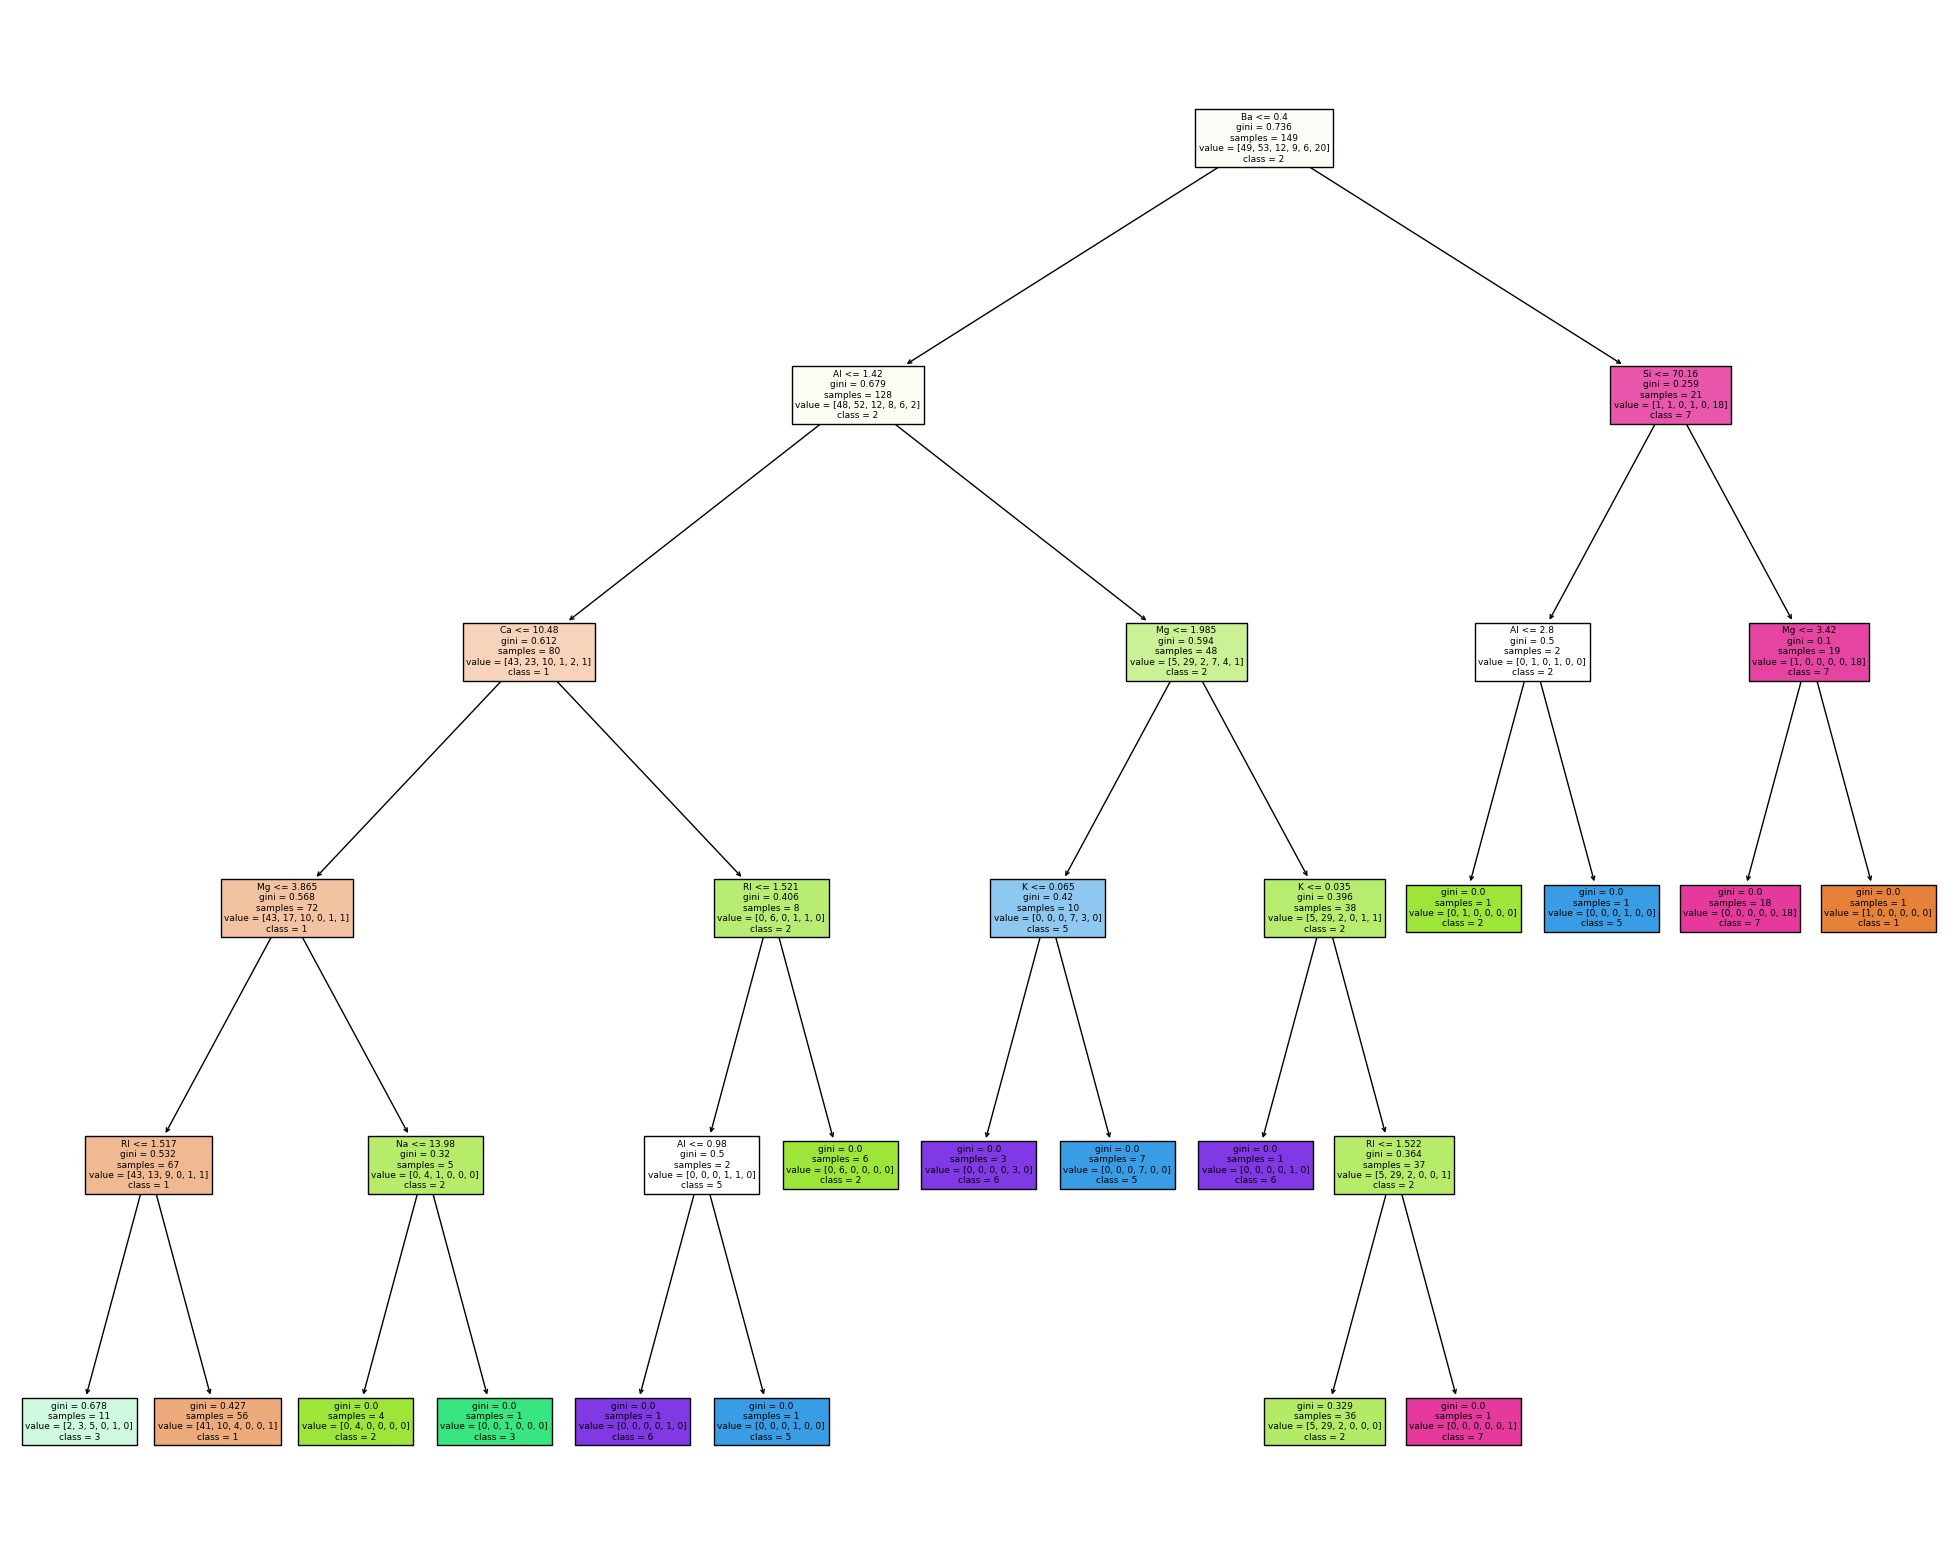

In [32]:
fig = plt.figure(figsize=(25,20))
sk_tree = tree.plot_tree(clf_pruned, 
                   feature_names=features,  
                   class_names=list(map(str, types.keys())),
                   filled=True)

In [33]:
## Calculating feature importance
feat_importance = clf_pruned.tree_.compute_feature_importances(normalize=False)
feat_imp_dict = dict(zip(features, clf_pruned.feature_importances_))
feat_imp = pd.DataFrame.from_dict(feat_imp_dict, orient='index')
feat_imp.rename(columns = {0:'FeatureImportance'}, inplace = True)
feat_imp.sort_values(by=['FeatureImportance'], ascending=False).head()

,FeatureImportance
Ba,0.259442
Mg,0.222673
Al,0.172961
RI,0.123019
K,0.087225


In [34]:
text_representation = tree.export_text(clf_pruned)
print(text_representation)

|--- feature_7 <= 0.40
|   |--- feature_3 <= 1.42
|   |   |--- feature_6 <= 10.48
|   |   |   |--- feature_2 <= 3.86
|   |   |   |   |--- feature_0 <= 1.52
|   |   |   |   |   |--- class: 3
|   |   |   |   |--- feature_0 >  1.52
|   |   |   |   |   |--- class: 1
|   |   |   |--- feature_2 >  3.86
|   |   |   |   |--- feature_1 <= 13.98
|   |   |   |   |   |--- class: 2
|   |   |   |   |--- feature_1 >  13.98
|   |   |   |   |   |--- class: 3
|   |   |--- feature_6 >  10.48
|   |   |   |--- feature_0 <= 1.52
|   |   |   |   |--- feature_3 <= 0.98
|   |   |   |   |   |--- class: 6
|   |   |   |   |--- feature_3 >  0.98
|   |   |   |   |   |--- class: 5
|   |   |   |--- feature_0 >  1.52
|   |   |   |   |--- class: 2
|   |--- feature_3 >  1.42
|   |   |--- feature_2 <= 1.98
|   |   |   |--- feature_5 <= 0.06
|   |   |   |   |--- class: 6
|   |   |   |--- feature_5 >  0.06
|   |   |   |   |--- class: 5
|   |   |--- feature_2 >  1.98
|   |   |   |--- feature_5 <= 0.04
|   |   |   |   |--- c

## Neural Network

### Not normalised

In [35]:
# train
w_1, b_1, w_2, b_2, loss_list = neural_net_train(X_train, y_train, 0.001, 5000)
# predict
nn_predictions = neural_net_predict(w_1, b_1, w_2, b_2, X_test)

In [36]:
# metrics
nn_accuracy = metrics.accuracy_score(y_test, nn_predictions)
nn_f1 = metrics.f1_score(y_test, nn_predictions, average='weighted')
print('Neural Network metric on data\nAccuracy: {}\nF1 score: {}'.format(nn_accuracy, nn_f1))

Neural Network metric on data
Accuracy: 0.35384615384615387
F1 score: 0.18496503496503494


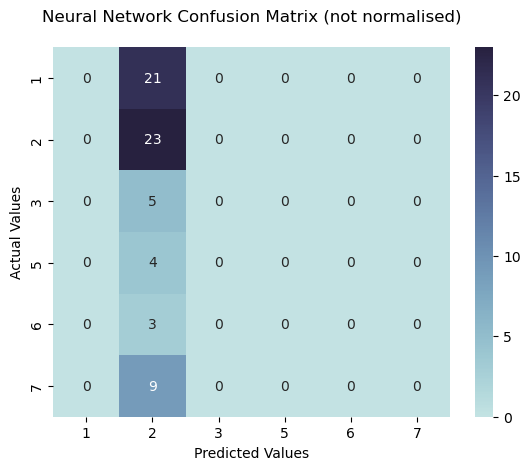

In [37]:
# make and plot confusion matrix
nn_cf_matrix = metrics.confusion_matrix(y_test, nn_predictions)
plot_cf_matrix(nn_cf_matrix, 'Neural Network Confusion Matrix (not normalised)')

### Normalised

In [38]:
# train
w2_1, b2_1, w2_2, b2_2, loss_list2 = neural_net_train(X_train_norm, y_train, 0.001, 5000)
# predict
nn2_predictions = neural_net_predict(w2_1, b2_1, w2_2, b2_2, X_test_norm)

In [39]:
# metrics
nn2_accuracy = metrics.accuracy_score(y_test, nn2_predictions)
nn2_f1 = metrics.f1_score(y_test, nn2_predictions, average='weighted')
print('Neural Network metric on data\nAccuracy: {}\nF1 score: {}'.format(nn2_accuracy, nn2_f1))

Neural Network metric on data
Accuracy: 0.6615384615384615
F1 score: 0.6327783102630972


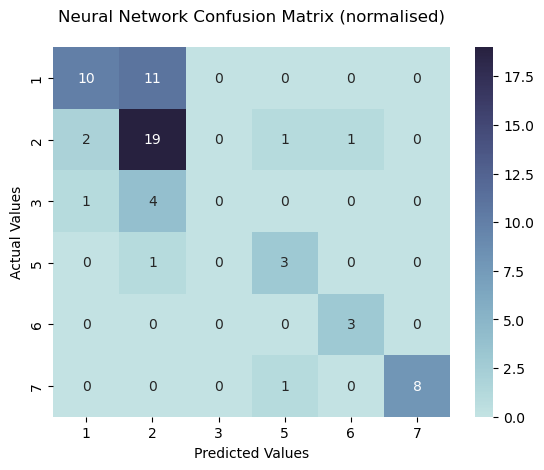

In [40]:
# make and plot confusion matrix
nn2_cf_matrix = metrics.confusion_matrix(y_test, nn2_predictions)
plot_cf_matrix(nn2_cf_matrix, 'Neural Network Confusion Matrix (normalised)')

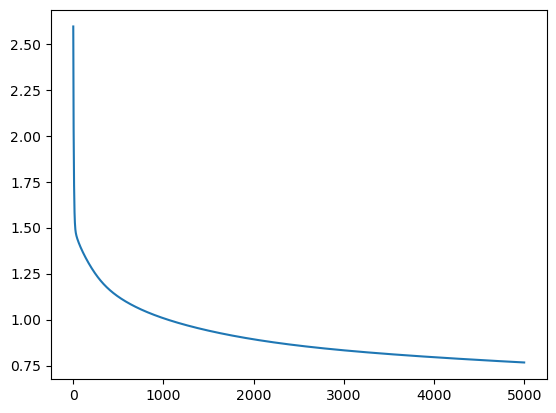

In [41]:
plt.plot(loss_list2);

### With PCA features

In [42]:
# train
w3_1, b3_1, w3_2, b3_2, loss_list3 = neural_net_train(pca_train, y_train, 0.001, 5000)
# predict
nn3_predictions = neural_net_predict(w3_1, b3_1, w3_2, b3_2, pca_test)

In [43]:
# metrics
nn3_accuracy = metrics.accuracy_score(y_test, nn3_predictions)
nn3_f1 = metrics.f1_score(y_test, nn3_predictions, average='weighted')
print('Neural Network metric on data\nAccuracy: {}\nF1 score: {}'.format(nn3_accuracy, nn3_f1))

Neural Network metric on data
Accuracy: 0.7384615384615385
F1 score: 0.744973443808526


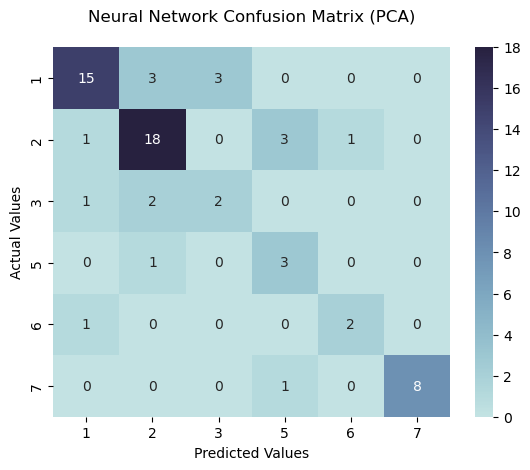

In [44]:
# make and plot confusion matrix
nn3_cf_matrix = metrics.confusion_matrix(y_test, nn3_predictions)
plot_cf_matrix(nn3_cf_matrix, 'Neural Network Confusion Matrix (PCA)')

### Comparison to sklearn
The method form the sklearn library performs better when not normalised.

#### Not normalised

In [45]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf_not = MLPClassifier(random_state=1, max_iter=5000, activation='logistic', hidden_layer_sizes=(1,)).fit(X_train, y_train)
clf_not.predict_proba(X_test)

clf_not.predict(X_test)

print('Sklearn MLPClassifier accuracy (not normalised):', clf_not.score(X_test, y_test))

Sklearn MLPClassifier accuracy (not normalised): 0.35384615384615387


#### Normalised

In [46]:
from sklearn.neural_network import MLPClassifier
from sklearn.datasets import make_classification

clf = MLPClassifier(random_state=1, max_iter=5000, activation='logistic').fit(X_train_norm, y_train)
clf.predict_proba(X_test_norm)

sk_nn_y_pred = clf.predict(X_test_norm)

print('Sklearn MLPClassifier accuracy (normalised):', clf.score(X_test_norm, y_test))

Sklearn MLPClassifier accuracy (normalised): 0.6


In [47]:
# metrics
sk_nn_acc = metrics.accuracy_score(y_test, sk_nn_y_pred)
sk_nn_f1 = metrics.f1_score(y_test, nn3_predictions, average='weighted')
print('Neural Network metric on data\nAccuracy: {}\nF1 score: {}'.format(sk_nn_acc, sk_nn_f1))

Neural Network metric on data
Accuracy: 0.6
F1 score: 0.744973443808526


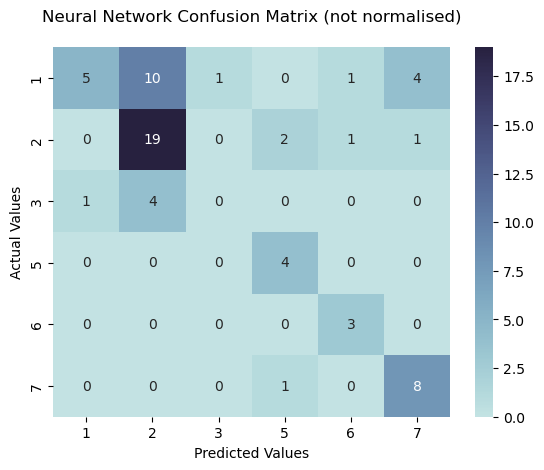

In [48]:
sk_nn_cf = metrics.confusion_matrix(y_test, sk_nn_y_pred)
plot_cf_matrix(sk_nn_cf, 'Neural Network Confusion Matrix (not normalised)')

## Random Forest 

When to use random forest?
- It can be used for both classification (RandomForestClassifier)and regression (RandomForestRegressor) problems
- You are interested in the significance of predictors (feature importance)
- You need a quick benchmark model as random forest are quick to train and require minimal preprocessing e.g. feature scaling
- If you have messy data e.g. missing data, outliers etc

When not to use random forest
- If you are solving a complex, novel problem
- Transparency is important
- Prediction time is important as the model needs time to aggregate the result from multiple decision trees before arriving at the final prediction

To wrap up on random forest, here are some key hyperparameters to consider:
- n_estimators: controls how many individual decision trees will be built
- max_depth: controls how deep each individual decision tree can go

Source: https://towardsdatascience.com/battle-of-the-ensemble-random-forest-vs-gradient-boosting-6fbfed14cb7

In [49]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import RandomForestClassifier

In [50]:
# Set up GridSearchCV
rf = RandomForestClassifier(random_state = 42)

params = {
    'n_estimators': [5, 10, 50, 100, 250],
    'max_depth': [2, 4, 8, 16, 32, None]
}

cv = GridSearchCV(rf, params, cv = 5, n_jobs = -1)

# fit GridSearchCV to training set 
cv.fit(X_train, y_train)

# get best parameters
cv.best_params_

{'max_depth': 8, 'n_estimators': 250}

In [51]:
rnd_clf = RandomForestClassifier(n_estimators=250, max_depth=8, n_jobs=-1)
rnd_clf.fit(X_train, y_train)
y_pred_rf = rnd_clf.predict(X_test)


In [52]:
metrics.accuracy_score(y_test, y_pred_rf), metrics.f1_score(y_test, y_pred_rf, average='weighted')

(0.8461538461538461, 0.8484008801655859)

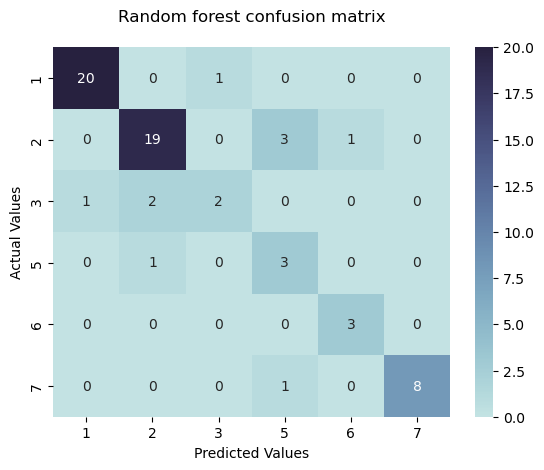

In [53]:
# make and plot confusion matrix
rf_cf_matrix = metrics.confusion_matrix(y_test, y_pred_rf)
plot_cf_matrix(rf_cf_matrix, 'Random forest confusion matrix')

# More sklearn models

In [54]:
from sklearn.svm import SVC

# training a linear SVM classifier
svm_model_linear = SVC(kernel = 'rbf', C = 2).fit(X_train, y_train)
svm_predictions = svm_model_linear.predict(X_test)

# model accuracy for X_test
svm_acc = svm_model_linear.score(X_test, y_test)
svm_cm = metrics.confusion_matrix(y_test, svm_predictions) 

print(svm_acc, '\n', svm_cm)

0.35384615384615387 
 [[ 0 21  0  0  0  0]
 [ 0 23  0  0  0  0]
 [ 0  5  0  0  0  0]
 [ 0  4  0  0  0  0]
 [ 0  3  0  0  0  0]
 [ 0  9  0  0  0  0]]


In [55]:
# training a KNN classifier
from sklearn.neighbors import KNeighborsClassifier
knn = KNeighborsClassifier(n_neighbors = 4).fit(X_train, y_train) # why 4? tried 1-5 and 4 was the best

# accuracy on X_test
knn_acc = knn.score(X_test, y_test)

# creating a confusion matrix
knn_predictions = knn.predict(X_test)
knn_cm = metrics.confusion_matrix(y_test, knn_predictions)

print(knn_acc, '\n', knn_cm)

0.676923076923077 
 [[19  1  1  0  0  0]
 [ 6 15  0  2  0  0]
 [ 5  0  0  0  0  0]
 [ 0  1  0  3  0  0]
 [ 0  3  0  0  0  0]
 [ 1  0  0  1  0  7]]


/home/sabrina/miniconda3/envs/uni/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/home/sabrina/miniconda3/envs/uni/lib/python3.10/site-packages/sklearn/neighbors/_classification.py:237: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None 